In [420]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [421]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [422]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [423]:
def remove_unused_columns(df):
    df = df.pop('wind_speed_10m:ms')

In [424]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in train.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    for key in constanst_columns:
        if val.std()[key] != 0.0 or test.std()[key] != 0.0:
            constanst_columns.remove(key)

    for key in constanst_columns:
        train = train.drop([key], axis=1)
        val = val.drop([key], axis=1)
        test = test.drop([key], axis=1)

In [425]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60
    year = (365.2425)*day
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [426]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]

In [427]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [428]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [429]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [430]:
# Remove columns which are not needed
remove_unused_columns(train_data_a)
remove_unused_columns(val_data_a)
remove_unused_columns(test_a)

remove_unused_columns(train_data_b)
remove_unused_columns(val_data_b)
remove_unused_columns(test_b)

remove_unused_columns(train_data_c)
remove_unused_columns(val_data_c)
remove_unused_columns(test_c)

In [431]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

In [432]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

In [433]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [434]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [435]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        
        self.not_label_columns = train_df.columns.tolist()
        for label_column in self.label_columns:
            self.not_label_columns.remove(label_column)
        
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
        
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def format_test_data(self, features):
        inputs = features[:, self.input_slice, :]

        # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        
        return inputs
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        
        inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.not_label_columns],
                axis=-1)
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
              data=data,
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=32,)

        ds = ds.map(self.split_window)
        
        return ds
    
    def make_test_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
              data=data,
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=False,
              batch_size=32,)

        ds = ds.map(self.format_test_data)
        
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_test_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='pv_measurement', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [439]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                      callbacks=[early_stopping])
    return history

In [437]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=32

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [438]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_x = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_x = split_and_batch(val_data_c)

In [340]:
#Define windows for each building

CONV_WIDTH = 3

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window_a = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,train_df=train_data_a, val_df=val_data_a,
                     test_df=test_a, label_columns=['pv_measurement'])

wide_conv_window_b = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,train_df=train_data_b, val_df=val_data_b,
                     test_df=test_b,label_columns=['pv_measurement'])

wide_conv_window_c = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,train_df=train_data_c, val_df=val_data_c,
                     test_df=test_c,label_columns=['pv_measurement'])

In [341]:
#Define model

conv_model_a = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),

    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_model_b = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),

    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_model_c = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),

    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Wide conv window")
print('Input shape:', wide_conv_window_a.example[0].shape)
print('Labels shape:', wide_conv_window_a.example[1].shape)
print('Output shape:', conv_model_a(wide_conv_window_a.example[0]).shape)

Wide conv window
Input shape: (32, 26, 48)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [442]:
val_a_y.shape

(137, 32, 48)

In [440]:
history_a = compile_and_fit(conv_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {conv_model_a.evaluate(wide_conv_window_a.val)}')

#history_b = compile_and_fit(conv_model_b, wide_conv_window_b)
#print(f'measure b: {conv_model_b.evaluate(wide_conv_window_b.val)}')

#history_c = compile_and_fit(conv_model_c, wide_conv_window_c)
#print(f'measure c: {conv_model_c.evaluate(wide_conv_window_c.val)}')

Epoch 1/20


ValueError: in user code:

    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\marti\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 30 and 32 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_142/dense_283/BiasAdd, IteratorGetNext:1)' with input shapes: [?,30,1], [?,32,1].


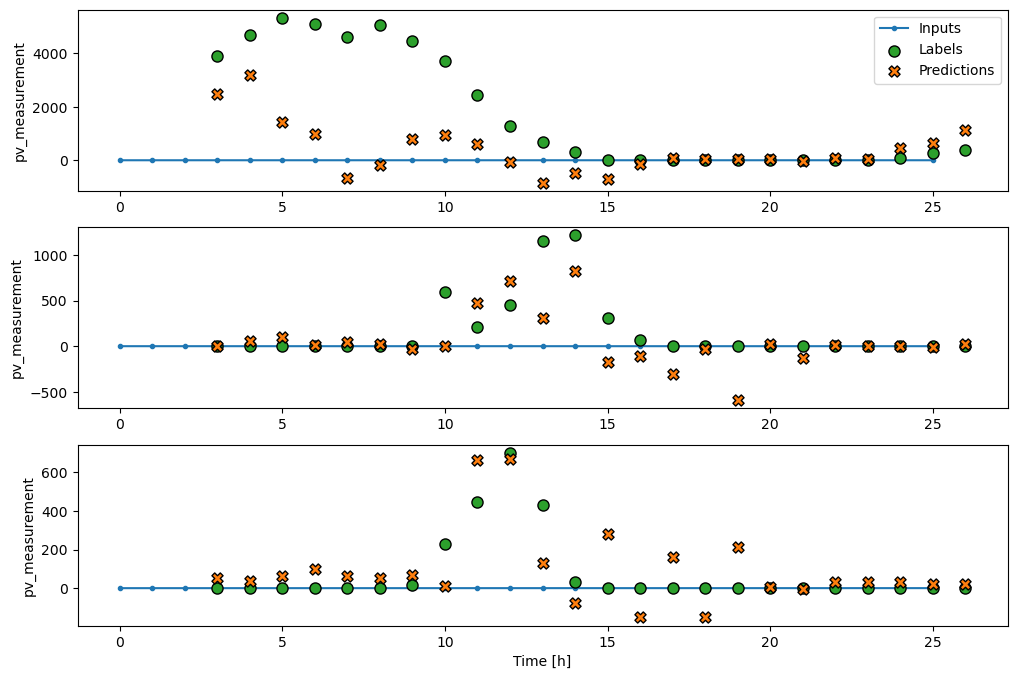

In [294]:
wide_conv_window_a.plot(conv_model_a)

In [21]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

Input shape: (32, 24, 46)
Output shape: (32, 24, 1)
Epoch 1/20
927/927 [==============================] - 18s 16ms/step - loss: 1873261.2500 - mean_absolute_error: 673.6074 - val_loss: 898447.5000 - val_mean_absolute_error: 342.8334
Epoch 2/20
927/927 [==============================] - 14s 15ms/step - loss: 1849622.0000 - mean_absolute_error: 671.2368 - val_loss: 886771.3750 - val_mean_absolute_error: 344.9162
Epoch 3/20
927/927 [==============================] - 16s 17ms/step - loss: 1826950.5000 - mean_absolute_error: 667.8736 - val_loss: 875789.9375 - val_mean_absolute_error: 344.7496
Epoch 4/20
927/927 [==============================] - 16s 17ms/step - loss: 1803787.3750 - mean_absolute_error: 663.9819 - val_loss: 864642.8750 - val_mean_absolute_error: 345.5628
Epoch 5/20
927/927 [==============================] - 18s 20ms/step - loss: 1782961.6250 - mean_absolute_error: 660.3268 - val_loss: 855181.1875 - val_mean_absolute_error: 346.8065
Epoch 6/20
927/927 [=======================

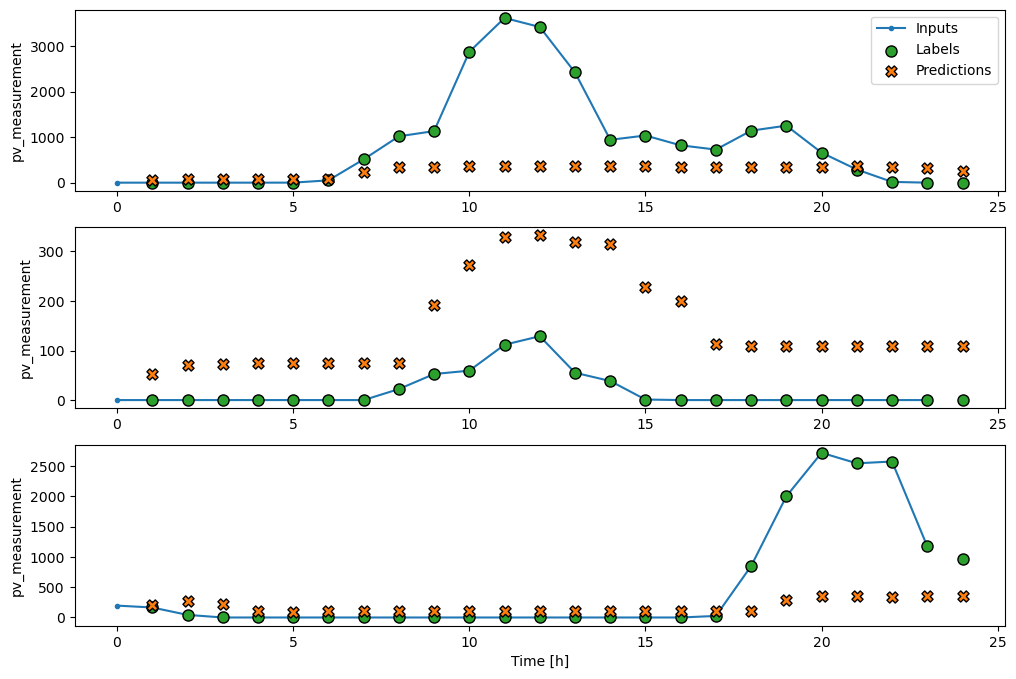

In [23]:
wide_window.plot(lstm_model)

In [359]:
"""
data = np.array(test_a, dtype=np.float32)
ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=wide_conv_window_a.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
"""



for batch in wide_conv_window_a.test:
    prediction = conv_model_a.predict(batch)
    
    print(prediction[0])
    break
    
    
#ys = conv_model_a.predict(wide_conv_window_a.test)
#print(ys.shape)

#xs = range(0, len(ys))
#plt.plot(xs, ys)


1/1 [==============================] - 0s 25ms/step
[[  -3749.0493]
 [  -4175.918 ]
 [  -8707.938 ]
 [ -20650.875 ]
 [ -48946.68  ]
 [ -79903.78  ]
 [-106676.03  ]
 [-135539.44  ]
 [-168884.47  ]
 [-193600.45  ]
 [-208174.84  ]
 [-214674.12  ]
 [-207341.31  ]
 [-175110.78  ]
 [-140795.47  ]
 [-111349.836 ]
 [ -78090.96  ]
 [ -58949.676 ]
 [ -31622.57  ]
 [  -9435.846 ]
 [  -3731.7803]
 [  -2813.2073]
 [  -1575.9393]
 [  -2670.992 ]]


In [25]:
test = pd.read_csv('test.csv')

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [10]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [11]:
# Example, let the predictions be random values
test['prediction'] = np.random.rand(len(test))
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)